In [1]:
import sys,os
import subprocess
import numpy as np
import pylab as py
import matplotlib.cm as cm
import sympy as sp
from sympy.printing.mathml import print_mathml,mathml
from sympy.parsing.sympy_parser import parse_expr
from sympy.tensor.array import MutableDenseNDimArray as Array
sp.init_printing() 
from IPython.display import display, Math, Latex
lprint=lambda expression: display(Math(sp.latex(expression)))
import copy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
class Vec(object): 

    def __init__(self,symbol,rep='LC',mod=[1,1,1,1],theta=None):
        if rep=='LC': self.vec=self.LC(symbol,mod=mod,theta=theta)
        if rep=='MC': self.vec=self.MC(symbol,mod=mod,theta=theta)
        self.rep=rep

    def __add__(self,other):
        dum=Vec('dum',self.rep)
        dum.vec=[self.vec[i]+other.vec[i] for i in range(len(other.vec))]
        return dum

    def __sub__(self,other):
        #print self.vec
        #print other.vec
        dum=Vec('dum',self.rep)
        dum.vec=[self.vec[i]-other.vec[i] for i in range(len(other.vec))]
        return dum

    def __eq__(self,other):
        dum=Vec('dum',self.rep)
        dum.vec=[self.vec[i] for i in range(len(other.vec))]
        return dum
 
    def __mul__(self,other):
        if isinstance(other, Vec): 
            return self.dot(other.vec,self.vec)
        else:
            dum=Vec('dum',self.rep)
            dum.vec=[other*self.vec[i] for i in range(len(self.vec))]
            return dum
        
    def __rmul__(self,other):
        if isinstance(other, Vec): 
            return self.dot(other.vec,self.vec)
        else:
            dum=Vec('dum',self.rep)
            dum.vec=[other*self.vec[i] for i in range(len(self.vec))]
            return dum
        
    def LC(self,symbol,mod=[1,1,1,1],theta=None):
        p=sp.S('%s_p'%symbol)
        m=sp.S('%s_m'%symbol)
        t=sp.symbols('%s_t'%symbol,positive = True, real = True)
        if theta==None: theta=sp.S('theta_%s'%symbol)
        vec=[p,m,t*sp.cos(theta),t*sp.sin(theta)]
        self.p=p
        self.m=m
        self.t=t
        return [vec[i]*mod[i] for i in range(4)]
    
    def MC(self,symbol,mod=[1,1,1,1],theta=None):
        E=sp.symbols('%s_E'%symbol,positive = True, real = True)
        z=sp.symbols('%s_z'%symbol,real = True)
        t=sp.symbols('%s_t'%symbol,positive = True, real = True)
        if theta==None: theta=sp.S('theta_%s'%symbol)
        vec=[E,t*sp.cos(theta),t*sp.sin(theta),z]
        self.E=E
        self.z=z
        self.t=t
        self.theta=theta
        return [vec[i]*mod[i] for i in range(4)]

    def dot(self,A,B):
        if self.rep=='LC':
            return A[0]*B[1]+A[1]*B[0]-A[2]*B[2]-A[3]*B[3]
        elif self.rep=='MC':
            return A[0]*B[0]-A[1]*B[1]-A[2]*B[2]-A[3]*B[3]
        
    def set_plus(self,plus):
        self.vec[0]=plus
        
    def set_minus(self,minus):
        self.vec[1]=minus
        
    def set_perp(self,perp):
        self.vec[2:]=perp
        
    def set_E(self,E):
        self.vec[0]=E
        
    def set_x(self,x):
        self.vec[1]=x
        
    def set_y(self,y):
        self.vec[2]=y
        
    def set_z(self,z):
        self.vec[3]=z

    def get_E(self):
        return self.vec[0]
        
    def get_x(self):
        return self.vec[1]
        
    def get_y(self):
        return self.vec[2]
        
    def get_z(self):
        return self.vec[3]

    
    def change_plus(self,M):
        if  self.rep=='LC':
            perp2=(self.vec[2]**2+self.vec[3]**2)#.simplify()
            self.vec[0]=(perp2+M**2)/2/self.vec[1]
        
    def change_minus(self,M):
        if  self.rep=='LC':
            perp2=(self.vec[2]**2+self.vec[3]**2)#.simplify()
            self.vec[1]=(perp2+M**2)/2/self.vec[0]

    def LC2MC(self):
        if  self.rep=='LC':
            vec0=((self.vec[0]+self.vec[1])/sp.sqrt(2))#.simplify()
            vec3=((self.vec[0]-self.vec[1])/sp.sqrt(2))#.simplify()
            self.vec=[vec0,self.vec[2],self.vec[3],vec3]
            self.rep='MC'

    def MC2LC(self):
        if  self.rep=='MC':
            vec_p=((self.vec[0]+self.vec[3])/sp.sqrt(2))#.simplify()
            vec_m=((self.vec[0]-self.vec[3])/sp.sqrt(2))#.simplify()
            self.vec=[vec_p,vec_m,self.vec[1],self.vec[2]]
            self.rep='LC'

    def norm(self):
        return sp.sqrt(sum([self.vec[i]**2 for i in range(1,4)]))#.simplify()
        
    def uvec(self):
        dum=Vec('dum','MC')
        dum.set_E(sp.S(0))
        norm=self.norm()
        dum.vec[1:]=[self.vec[i]/norm for i in range(1,len(self.vec))]
        return dum
    
    def get_mass(self):
        if self.rep=='MC':
            return sp.sqrt(self.vec[0]**2-self.norm()**2)
        elif self.rep=='LC':
            return sp.sqrt(2*self.vec[0]*self.vec[1]-self.vec[2]**2-self.vec[3]**2)

    def get_sqmass(self):
        if self.rep=='MC':
            return self.vec[0]**2-self.norm()**2
        elif self.rep=='LC':
            return 2*self.vec[0]*self.vec[1]-self.vec[2]**2-self.vec[3]**2

    @staticmethod
    def dot3(A,B):
        return sum([A.vec[i]*B.vec[i] for i in range(1,4)])
    
    @staticmethod
    def cross(A,B):
        dum=Vec('dum','MC')
        dum.set_E(sp.S(0))
        x= A.vec[2]*B.vec[3]-A.vec[3]*B.vec[2]
        y=-A.vec[1]*B.vec[3]+A.vec[3]*B.vec[1]
        z= A.vec[1]*B.vec[2]-A.vec[2]*B.vec[1]
        dum.vec[1:]=[x,y,z]
        return dum
    
    def simplify_vec(self):
        for i in range(4):
            self.vec[i]=self.vec[i].simplify()

    def subs_vec(self,A,B):
        for i in range(4):
            self.vec[i]=self.vec[i].subs(A,B)

    
    def rotate(self,K,cos,sin):
        #--rootate around K 
        dum=Vec('dum','MC')
        UK=K.uvec()
        dum.vec[1:]=(self*cos+self.cross(UK,self)*sin+UK*(self.dot3(UK,self)*(1-cos))).vec[1:]
        dum.vec[0]=self.vec[0]
        return dum
        
    def get_cos(self,K):
        #--get cos along K
        UK=K.uvec()
        UV=self.uvec()
        return self.dot3(UV,UK)
    
    def get_sin(self,K):
        #--get sin along K
        UK=K.uvec()
        UV=self.uvec()
        return self.cross(UV,UK).norm()
        
    @staticmethod
    def get_boost_CS(A,bA):
        #--get cosh and sinsh for A -> boosted A (bA)
        #--A and bA are 2D vectors 0: energy, 1: momentum along boost dir
        cosh=(bA[1]*A[1]-bA[0]*A[0])/(A[1]**2-A[0]**2)
        if A[1]==0: sinh=(bA[1]-cosh*A[1])/A[0]
        else:       sinh=(bA[0]-cosh*A[0])/A[1]
        return cosh,sinh
        
    def boost(self,V,C=None,S=None):
        
        if C==None and S==None:
            #--boost to rest frame of V
            E=V.vec[0]
            P=V.norm()
            M=V.get_mass()
            C,S=self.get_boost_CS([E,P],[M,0])
            
        UV=V.uvec()
        par=self.dot3(self,UV)*UV
        per=self-par
        E=self.vec[0]
        npar=self.dot3(self,UV)#par.norm()
        #npar=par.norm()
        bE  =(C*E + S*npar)#.simplify()
        bpar=(S*E + C*npar)#.simplify()
        new=per+bpar*UV
        new.vec[0]=bE
        return new
        

In [3]:

def gen_params():
    params={}

    params['M']   = 0.938
    params['M_h'] = 0.139

    params['x_bj']= 0.1
    params['z_h'] = 0.1
    params['Q']   = 10.0
    params['T_t'] = 0.1

    params['xi']  = 0.3
    params['zeta']= 0.3
    params['delta_k_t']=0.1
    params['k_i_t']=0.01
    params['M_ki']=0.1
    params['M_kf']=0.1
    return params


def evaluate(func,params=None,verb=False):
    
    if params==None: params=gen_params()
        
    msg=func.__doc__.replace(' ','').split('func(')[1].split('Expression')[0]
    msg=msg.replace('\n','').rstrip(')').split(',')
    if verb: print msg
    for _ in msg: 
        if _ not in params: 
            print '%s is missing in params'%_
            return None
    
    args=[params[_] for _ in msg]
    return func(*args)

In [4]:
def get_massless(exp,replace=[],n=3):
    if len(replace)>0:
        for _ in replace:
            A,B=_
            exp=exp.subs(A,B)
    exp=exp.subs(Q,1/eps)        
    return sp.series(exp,eps,0,n=n).subs(eps,1/Q).removeO()

In [5]:
xb=sp.symbols('x_bj',positive = True, real = True)
xN=sp.symbols('x_N',positive = True, real = True)
zh=sp.symbols('z_h',positive = True, real = True)
zN=sp.symbols('z_N',positive = True, real = True)
xh=sp.symbols('x_h',positive = True, real = True)

Q=sp.symbols('Q',positive = True, real = True)
M=sp.symbols('M',positive = True, real = True)
Mh=sp.symbols('M_h',positive = True, real = True)
Mki=sp.symbols('M_ki',positive = True, real = True)
Mkf=sp.symbols('M_kf',positive = True, real = True)
Mx=sp.symbols('M_x',positive = True, real = True)

MhT=sp.symbols('M_hT',positive = True, real = True)
qt=sp.S('q_t')
eps=sp.S('epsilon')
xi=sp.symbols('xi',positive = True, real = True)
zeta=sp.symbols('zeta',positive = True, real = True)
hxN=sp.symbols('\hat{x}_N',positive = True, real = True)
hzN=sp.symbols('\hat{z}_N',positive = True, real = True)

In [6]:
ki=Vec('k_i','LC',theta=0)
kf=Vec('k_f','LC',theta=0)
kx=Vec('k_x','LC',theta=0)

q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
H=Vec('H','LC',theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
dk=Vec('delta_k',theta=0,mod=[0,0,1,1])

q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)

ki.set_plus((xN/hxN)*P.vec[0])
kf.set_minus(H.vec[1]/(zN/hzN))
kf.set_perp((-hzN*T+dk).vec[2:])

ki.change_minus(Mki)
kf.change_plus(Mkf)

In [7]:
def build(exp):
    exp=exp.subs(hzN,zN/zeta)
    exp=exp.subs(hxN,xN/xi)
    exp=exp.subs(zN,zN2zh)
    exp=exp.subs(xN,xN2xb)
    exp=exp.subs(Mki**2,-Mki**2)
    args=(M,Mh,xb,zh,Q,T.t,xi,zeta,dk.t,ki.t,Mki,Mkf)
    return sp.lambdify(args, exp)



## build xN and zN variables

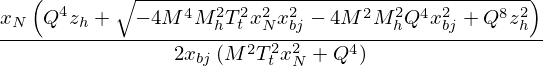

In [8]:
zN2zh=sp.solve(zh-2*xb*(P*H)/Q**2,zN)[1]
zN2zh=zN2zh.simplify()
zN2zh

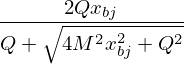

In [9]:
xN2xb=sp.solve(xb-Q**2/(2*P*q),xN)[0]
xN2xb=xN2xb*(Q+sp.sqrt(Q**2+4*M**2*xb**2))
xN2xb=xN2xb.expand()
xN2xb/=(Q+sp.sqrt(Q**2+4*M**2*xb**2))
xN2xb

In [10]:
get_xN=build(xN2xb)
print evaluate(get_xN)

0.09999120310791045


In [11]:
get_zN=build(zN2zh)
print evaluate(get_zN)

0.09999103224830468


## build R1..R4 variables

In [12]:
dk.vec

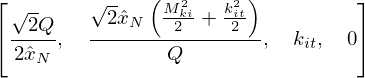

In [13]:
ki.vec

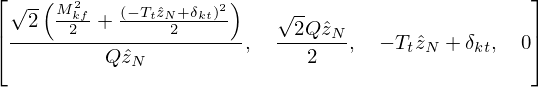

In [14]:
kf.vec


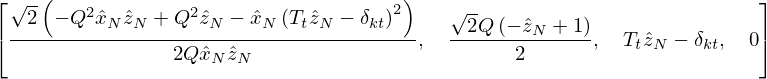

In [15]:
kx=ki+q-kf
kx.simplify_vec()
kx.vec=[_.subs(Mkf,0).subs(Mki,0).subs(ki.t,0) for _ in kx.vec]
Mx2_val=kx.get_sqmass()
kx.vec

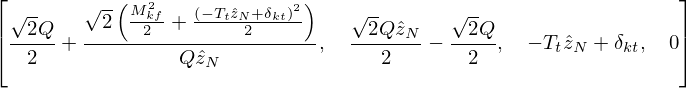

In [16]:
k=kf-q
k.vec

In [17]:
params=gen_params()
params

{'M': 0.938,
 'M_h': 0.139,
 'M_kf': 0.1,
 'M_ki': 0.1,
 'Q': 10.0,
 'T_t': 0.1,
 'delta_k_t': 0.1,
 'k_i_t': 0.01,
 'x_bj': 0.1,
 'xi': 0.3,
 'z_h': 0.1,
 'zeta': 0.3}

### build R1

In [18]:
R1=(H*kf)/(H*ki)
R1=R1.simplify()
lprint(R1)
get_R1=build(R1)
print evaluate(get_R1)

<IPython.core.display.Math object>

0.0023467666454413194


### build R2

In [19]:
R2=(k.get_sqmass()/Q**2)
R2=R2.simplify()
lprint(R2)
get_R2=build(R2)
print evaluate(get_R2)

<IPython.core.display.Math object>

-0.6670299433277364


### build R3

In [20]:
R3=(kx.get_sqmass()/Q**2)
R3=R3.simplify()
lprint(R3)
get_R3=build(R3)
print evaluate(get_R3)

<IPython.core.display.Math object>

1.3334357223046278


### build R4

In [21]:
R4=H*P/Q**2
R4=R4.simplify()
R4
lprint(R4)
get_R4=build(R4)
print evaluate(get_R4)

<IPython.core.display.Math object>

0.49999999999999994


## build rapidities

### proton 

In [22]:
yp=1/sp.S(2)*sp.log(P.vec[0]/P.vec[1]).simplify()
lprint(yp)
get_yp=build(yp)
print evaluate(get_yp)

<IPython.core.display.Math object>

4.669263488754392


### hadron

In [23]:
yh=1/sp.S(2)*sp.log(H.vec[0]/H.vec[1]).simplify()
lprint(yh)
get_yh=build(yh)
print evaluate(get_yh)

<IPython.core.display.Math object>

-1.9706109422661016


### incomming parton

In [24]:
yi=(1/sp.S(2)*sp.log(ki.vec[0]/ki.vec[1])).simplify()
lprint(yi)
get_yi=build(yi)
print evaluate(get_yi)

<IPython.core.display.Math object>

(5.708895615373339-1.5707963267948966j)


### outgoing parton

In [25]:
yf=(1/sp.S(2)*sp.log(kf.vec[0]/kf.vec[1])).simplify()
lprint(yf)
get_yf=build(yf)
print evaluate(get_yf)

<IPython.core.display.Math object>

-3.322592029059071


## Test 1

In [26]:
def update(xb=0.1,Q=1.5,qT=0,Mki=0.1,Mkf=0.1,dkT=0.1,kiT=0.1):
    
    params=gen_params()
    params['M_ki']=Mki
    params['M_kf']=Mkf
    params['T_t']=qT
    params['delta_k_t']=dkT
    params['k_i_t']=kiT
    params['xi']=xb
    params['x_bj']=xb
    params['Q']=Q
    
    zh=np.linspace(0.1,1,100)
    params['z_h']=zh
    params['zeta']=zh
    

    R={}
    R[1]=evaluate(get_R1,params)
    R[2]=evaluate(get_R2,params)
    R[3]=evaluate(get_R3,params)
    for _ in R: R[_]=np.abs(R[_])

    nrows,ncols=1,3
    fig = py.figure(figsize=(ncols*4,nrows*4))
    AX={}
    AX[1]=py.subplot(nrows,ncols,1)
    AX[2]=py.subplot(nrows,ncols,2)
    AX[3]=py.subplot(nrows,ncols,3)
    
    for i in [1,2,3]:
        AX[i].plot(zh,R[i])
        AX[i].set_ylim(0,1)
        AX[i].set_xlim(0,1)
        AX[i].set_xlabel(r'$z_h$',size=20)
        AX[i].set_ylabel(r'$R_%d$'%i,size=20)
        AX[i].tick_params(axis='both', which='major',labelsize=13)
    
    py.tight_layout()
    fig.canvas.draw()
        
        
interact(update,xb=(0.,1),Q=(0.,2),qT=(0.,2),\
         Mki=(0.,1),Mkf=(0.,1),kiT=(0.,1),dkT=(0.,1));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMSwgZGVzY3JpcHRpb249dSd4YicsIG1heD0xLjApLCBGbG9hdFNsaWRlcih2YWx1ZT0xLjUsIGRlc2NyaXB0aW9uPXXigKY=


## Test 2

In [27]:
def update(zh=0.25,qT=0,Mki=0.1,Mkf=0.1,dkT=0.1,xi=0.1,zeta=0.3):
    
    params=gen_params()
    params['M_ki']=Mki
    params['M_kf']=Mkf
    params['T_t']=qT
    params['delta_k_t']=dkT
    params['xi']=xi
    params['zeta']=zeta    
    
    xb=np.linspace(0.1,0.2,100)
    Q=np.linspace(0.8,2,100)
    xb,Q = np.meshgrid(xb, Q)

    params['x_bj']=xb
    params['Q']=Q
    
    R={}
    R[1]=evaluate(get_R1,params)
    R[2]=evaluate(get_R2,params)
    R[3]=evaluate(get_R3,params)
    for _ in R: R[_]=np.abs(R[_])
    levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]

    nrows,ncols=1,3
    fig = py.figure(figsize=(ncols*6,nrows*6))
    AX={}
    AX[1]=py.subplot(nrows,ncols,1)
    AX[2]=py.subplot(nrows,ncols,2)
    AX[3]=py.subplot(nrows,ncols,3)
    
    for i in [1,2,3]:
        CS =AX[i].contour(xb,Q,R[i],levels=levels)
        AX[i].clabel(CS, inline=1, fontsize=10)
        AX[i].set_xlabel(r'$x_b$',size=20)
        AX[i].set_ylabel(r'$Q$',size=20)
        AX[i].set_title(r'$R_%d$ profile'%i,size=20)
        AX[i].tick_params(axis='both', which='major',labelsize=13)
    
    py.tight_layout()
    fig.canvas.draw()

interact(update,zh=(0.1,1),qT=(0.,10),Mki=(0.,1),Mkf=(0.,1),dkT=(0.,1),xi=(0.1,1),zeta=(0.1,1));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMjUsIGRlc2NyaXB0aW9uPXUnemgnLCBtYXg9MS4wLCBtaW49MC4xKSwgRmxvYXRTbGlkZXIodmFsdWU9MC4wLCBkZXPigKY=


In [27]:
import plotly.plotly as py
py.plotly.tools.set_credentials_file(username='nsato', api_key='BfoNfECD2G8RmMcLmJ7A')


In [29]:
data = [dict(
        visible = False,
        line=dict(color='#00CED1', width=6),
        name = '𝜈 = '+str(step),
        x = np.arange(0,10,0.01),
        y = np.sin(step*np.arange(0,10,0.01))) for step in np.arange(0,5,0.1)]
#data[10]['visible'] = True

steps = []
for i in range(len(data)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "Frequency: "},
    pad = {"t": 50},
    steps = steps
)]

layout = dict(sliders=sliders)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Sine Wave Slider')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~nsato/0 or inside your plot.ly account where it is named 'Sine Wave Slider'


In [29]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Contour(
        z=[[10, 10.625, 12.5, 15.625],
           [5.625, 6.25, 8.125, 11.25, 15.625],
           [2.5, 3.125, 5., 8.125, 12.5],
           [0.625, 1.25, 3.125, 6.25, 10.625],
           [0, 0.625, 2.5, 5.625, 10]]
    )
]
py.iplot(data)

In [30]:
np.nan

In [30]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

xx=np.linspace(-3.5, 3.5, 100)
yy=np.linspace(-3.5, 3.5, 100)
x,y=np.meshgrid(xx, yy)
z=np.exp(-(x-1)**2-y**2)-10*(x**3+y**4-x/5)*np.exp(-(x**2+y**2))

In [31]:
colorscale=[[0.0, 'rgb(20,29,67)'],
           [0.1, 'rgb(28,76,96)'],
           [0.2, 'rgb(16,125,121)'],
           [0.3, 'rgb(92,166,133)'],
           [0.4, 'rgb(182,202,175)'],
           [0.5, 'rgb(253,245,243)'],
           [0.6, 'rgb(230,183,162)'],
           [0.7, 'rgb(211,118,105)'],
           [0.8, 'rgb(174,63,95)'],
           [0.9, 'rgb(116,25,93)'],
           [1.0, 'rgb(51,13,53)']]

In [46]:
textz = [['x: '+'{:0.5f}'.format(x[i][j])+'<br>y: '+'{:0.5f}'.format(y[i][j])+
        '<br>z: '+'{:0.5f}'.format(z[i][j]) for j in range(z.shape[1])] for i in range(z.shape[0])]

trace1= go.Surface(
    x=tuple(x),
    y=tuple(y),
    z=tuple(z),
    #colorscale=colorscale,
    #text=textz,
    hoverinfo='text',
)

In [47]:
axis = dict(
showbackground=True, 
backgroundcolor="rgb(230, 230,230)", 
showgrid=False,    
zeroline=False,  
showline=False)

ztickvals=list(range(-6,4))
layout = go.Layout(title="Projections of a surface onto coordinate planes" , 
                autosize=False,
                width=700,
                height=600,
#                 scene=dict(xaxis=dict(axis, range=[-3.5, 3.5]),
#                             yaxis=dict(axis, range=[-3.5, 3.5]),
#                             zaxis=dict(axis , tickvals=ztickvals),
#                             aspectratio=dict(x=1,
#                                              y=1,
#                                              z=0.95)
#                            )
                )

In [48]:



data=[trace1]#, tracex, tracey, tracez]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)